# Advanced AirBNB Boston Price Prediction

This notebook presents an in-depth analysis of the Boston AirBNB dataset with a focus on predicting listing prices. We'll implement sophisticated feature engineering techniques and advanced modeling approaches to achieve high predictive accuracy.

## Table of Contents
1. [Introduction](#introduction)
2. [Data Loading and Exploration](#data-loading)
3. [Data Preprocessing](#preprocessing)
4. [Advanced Feature Engineering](#feature-engineering)
5. [Model Building and Evaluation](#modeling)
6. [Ensemble Methods](#ensemble)
7. [Feature Importance Analysis](#feature-importance)
8. [Error Analysis](#error-analysis)
9. [Review Analysis](#review-analysis)
10. [Conclusions and Recommendations](#conclusions)

## 1. Introduction <a id="introduction"></a>

The short-term rental market, dominated by platforms like AirBNB, has transformed the hospitality industry. Understanding the factors that influence pricing is crucial for hosts, travelers, and market analysts. This analysis aims to build a predictive model for AirBNB listing prices in Boston, leveraging a comprehensive dataset of property characteristics, host attributes, and guest reviews.

Our goal is to develop a model with high predictive accuracy, as measured by R-squared and RMSE metrics. Through advanced feature engineering and ensemble modeling techniques, we'll create a robust price prediction system that captures the complex relationships between various factors and listing prices.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import ElasticNet, Ridge, Lasso, HuberRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.decomposition import PCA
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
import re
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

## 2. Data Loading and Exploration <a id="data-loading"></a>

We'll begin by loading the Boston AirBNB dataset and exploring its structure and content. This dataset contains detailed information about listings, including property characteristics, host information, location data, and guest reviews.

In [ ]:
# Load the dataset
airbnb_listings = 'https://data.insideairbnb.com/united-states/ma/boston/2024-06-22/data/listings.csv.gz'
listings_df = pd.read_csv(airbnb_listings, compression='gzip')

print(f"Dataset shape: {listings_df.shape}")
print(f"Number of columns: {listings_df.shape[1]}")
print(f"Number of rows: {listings_df.shape[0]}")

Dataset shape: (4325, 75)
Number of columns: 75
Number of rows: 4325


In [ ]:
# Display the first few rows of the dataset
listings_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,20240622024514,2024-06-22,city scrape,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,"Mostly quiet ( no loud music, no crowed sidewa...",https://a0.muscache.com/pictures/24670/b2de044...,4804,https://www.airbnb.com/users/show/4804,Frank,2008-12-03,"Massachusetts, United States",My wife and I and grown children frequently oc...,within a day,80%,33%,t,https://a0.muscache.com/im/users/4804/profile_...,https://a0.muscache.com/im/users/4804/profile_...,East Boston,4,5,"['email', 'phone']",t,f,Neighborhood highlights,East Boston,NaN,42.364,-71.030,Entire rental unit,Entire home/apt,2,1.000,1 bath,1.000,1.000,"[""Central air conditioning"", ""Free street park...",$125.00,29,1125,29,29,1125,1125,29.000,1125.000,NaN,t,0,12,42,317,2024-06-22,25,1,0,2015-07-10,2023-12-11,4.960,5.000,4.960,5.000,4.960,4.840,4.880,NaN,f,1,1,0,0,0.230
1,5506,https://www.airbnb.com/rooms/5506,20240622024514,2024-06-22,city scrape,** Fort Hill Inn Private! Minutes to center!**,"Private guest room with private bath, You do n...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/miso/Hosting-...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,"Boston, MA","Relaxed, Easy going, Accommodating.",within an hour,100%,99%,t,https://a0.muscache.com/im/users/8229/profile_...,https://a0.muscache.com/im/users/8229/profile_...,Roxbury,11,14,"['email', 'phone']",t,t,Neighborhood highlights,Roxbury,NaN,42.328,-71.096,Entire guest suite,Entire home/apt,2,1.000,1 bath,1.000,1.000,"[""Fire extinguisher"", ""Free street parking"", ""...",$139.00,3,90,1,3,1125,1125,3.000,1125.000,NaN,t,6,18,31,112,2024-06-22,123,5,0,2009-03-21,2024-04-24,4.790,4.880,4.900,4.950,4.890,4.560,4.750,STR-490093,f,10,10,0,0,0.660
2,6695,https://www.airbnb.com/rooms/6695,20240622024514,2024-06-22,city scrape,"Fort Hill Inn *Sunny* 1 bedroom, condo duplex","Comfortable, Fully Equipped private apartment...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,"Boston, MA","Relaxed, Easy going, Accommodating.",within an hour,100%,99%,t,https://a0.muscache.com/im/users/8229/profile_...,https://a0.muscache.com/im/users/8229/profile_...,Roxbury,11,14,"['email', 'phone']",t,t,Neighborhood highlights,Roxbury,NaN,42.328,-71.094,Entire condo,Entire home/apt,4,1.000,1 bath,0.000,2.000,"[""Fire extinguisher"", ""Free street parking"", ""...",$179.00,3,730,1,3,730,730,2.900,730.000,NaN,t,4,9,19,79,2024-06-22,128,4,0,2009-08-06,2024-04-16,4.810,4.820,4.870,4.900,4.950,4.520,4.720,STR-491702,f,

In [ ]:
# Check column data types
listings_df.dtypes.value_counts()

,count
object,35
int64,23
float64,17


In [ ]:
# Check for missing values
missing_values = listings_df.isnull().sum()
missing_percent = (missing_values / len(listings_df)) * 100

missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
})

# Display columns with missing values, sorted by percentage
missing_data[missing_data['Missing Values'] > 0].sort_values('Percentage', ascending=False).head(20)

,Missing Values,Percentage
neighbourhood_group_cleansed,4325,100.000
calendar_updated,4325,100.000
neighbourhood,1586,36.671
neighborhood_overview,1586,36.671
license,1533,35.445
host_about,1345,31.098
review_scores_location,1009,23.329
review_scores_checkin,1009,23.329
review_scores_value,1009,23.329
review_scores_accuracy,1008,23.306


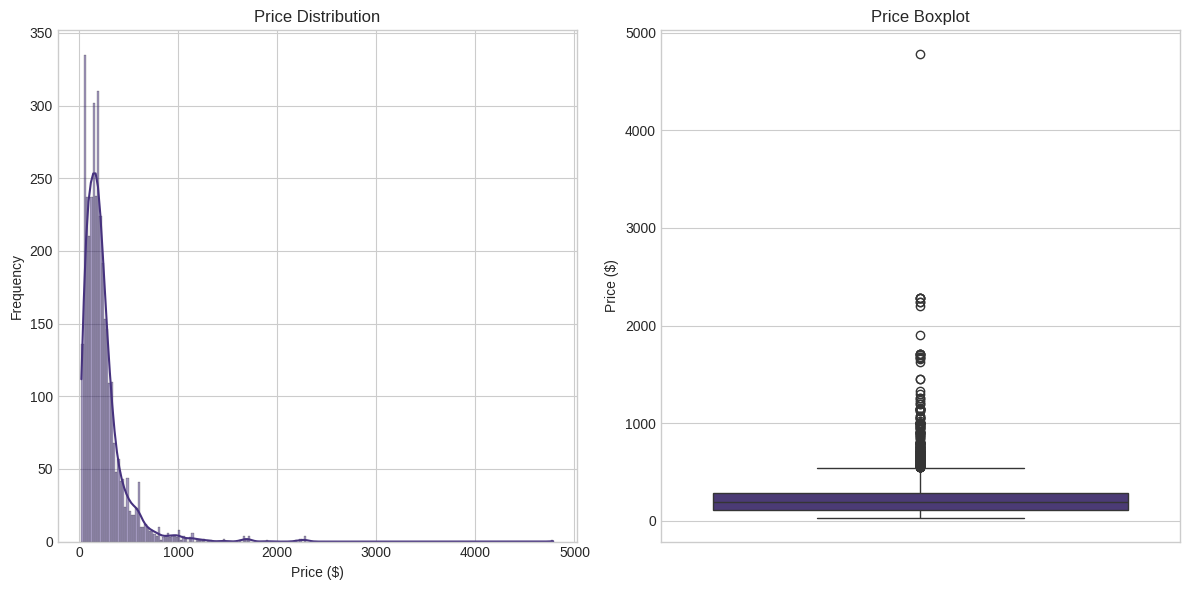

,price_numeric
count,3543.000
mean,239.949
std,230.967
min,25.000
25%,112.000
50%,190.000
75%,285.000
max,4786.000


In [ ]:
# Function to extract numeric value from price string
def extract_price(price_str):
    if pd.isna(price_str):
        return np.nan
    return float(re.sub(r'[^\d.]', '', price_str))

# Convert price to numeric
listings_df['price_numeric'] = listings_df['price'].apply(extract_price)

# Examine the price distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(listings_df['price_numeric'].dropna(), kde=True)
plt.title('Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=listings_df['price_numeric'].dropna())
plt.title('Price Boxplot')
plt.ylabel('Price ($)')

plt.tight_layout()
plt.show()

# Display price statistics
listings_df['price_numeric'].describe()

### Exploring Key Features

Let's examine some key features that might influence listing prices, such as property type, room type, neighborhood, and number of accommodates.

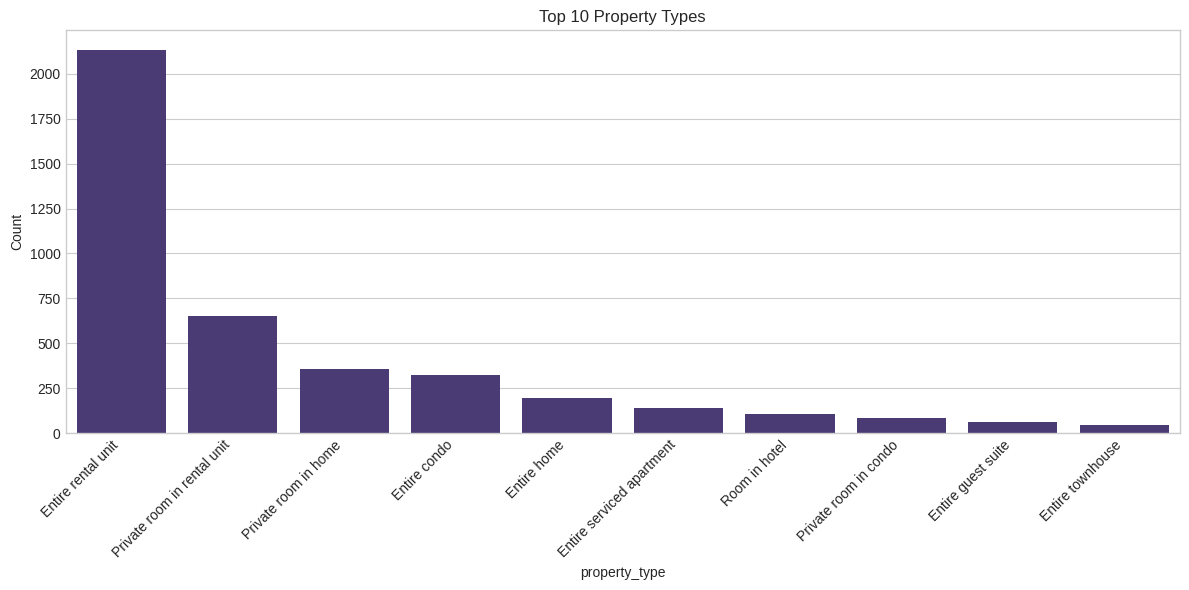

In [ ]:
# Explore property types
property_counts = listings_df['property_type'].value_counts()
top_properties = property_counts.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_properties.index, y=top_properties.values)
plt.title('Top 10 Property Types')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

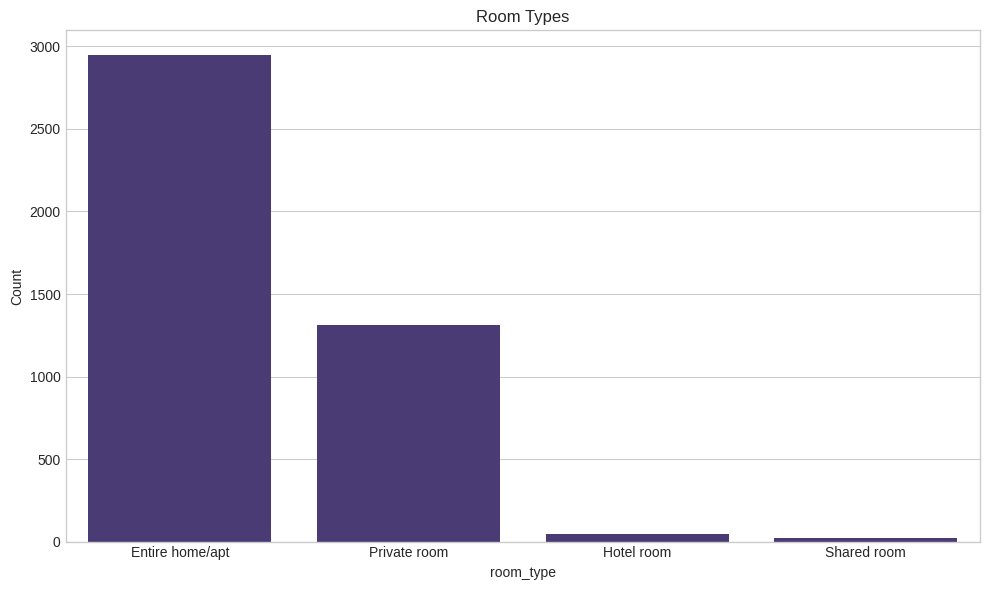

In [ ]:
# Explore room types
room_counts = listings_df['room_type'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=room_counts.index, y=room_counts.values)
plt.title('Room Types')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

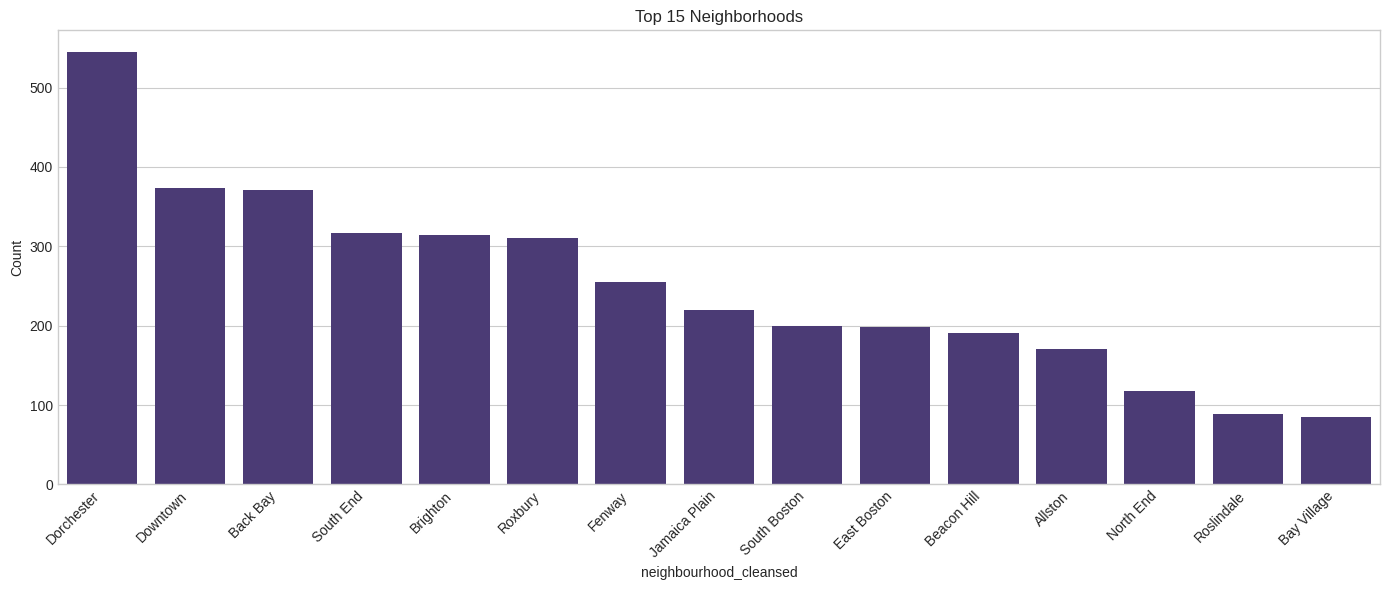

In [ ]:
# Explore neighborhoods
neighborhood_counts = listings_df['neighbourhood_cleansed'].value_counts()
top_neighborhoods = neighborhood_counts.head(15)

plt.figure(figsize=(14, 6))
sns.barplot(x=top_neighborhoods.index, y=top_neighborhoods.values)
plt.title('Top 15 Neighborhoods')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

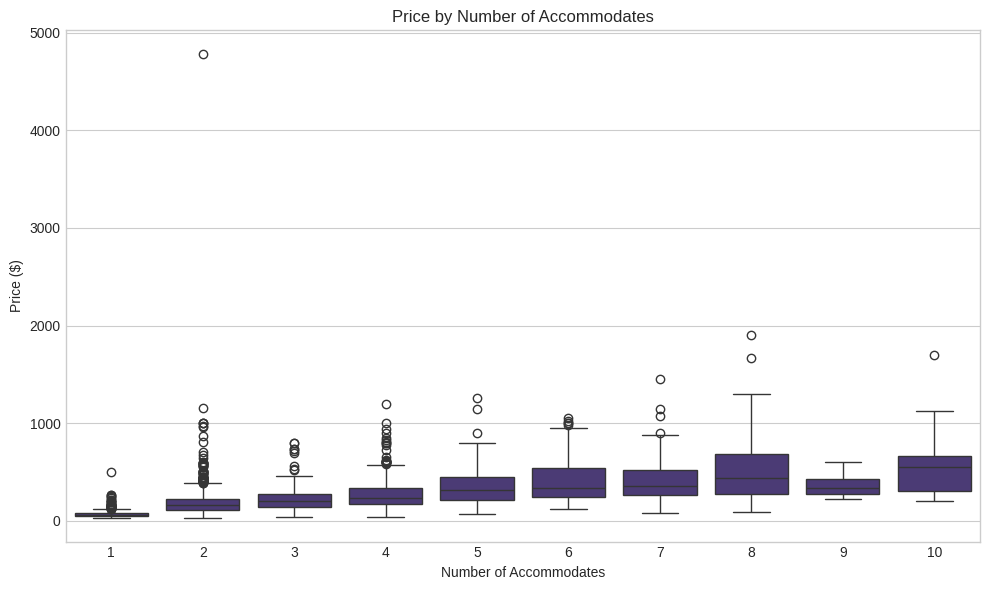

In [ ]:
# Explore relationship between accommodates and price
plt.figure(figsize=(10, 6))
sns.boxplot(x='accommodates', y='price_numeric', data=listings_df[listings_df['accommodates'] <= 10])
plt.title('Price by Number of Accommodates')
plt.xlabel('Number of Accommodates')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()

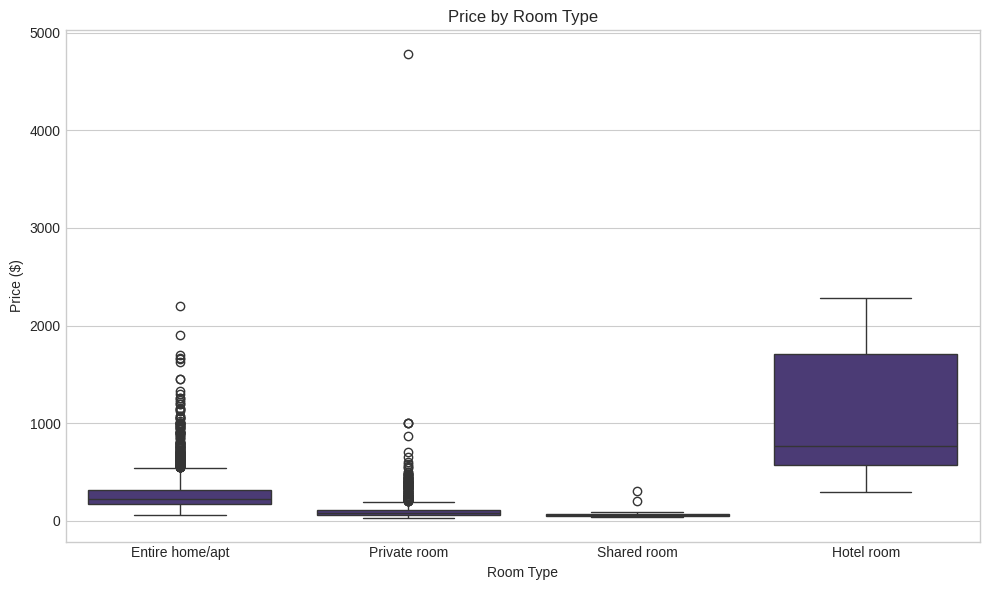

In [ ]:
# Explore relationship between room type and price
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price_numeric', data=listings_df)
plt.title('Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()

### Correlation Analysis

Let's examine the correlations between numeric features and price to identify potential predictors.

In [ ]:
# Select numeric columns
numeric_cols = listings_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'id' and 'price' not in col]

# Calculate correlations with price
correlations = listings_df[numeric_cols + ['price_numeric']].corr()['price_numeric'].sort_values(ascending=False)

# Display top positive and negative correlations
print("Top positive correlations with price:")
print(correlations.head(10))
print("\nTop negative correlations with price:")
print(correlations.tail(10))

Top positive correlations with price:
price_numeric               1.000
accommodates                0.607
bathrooms                   0.524
beds                        0.492
bedrooms                    0.386
host_id                     0.196
latitude                    0.186
review_scores_location      0.164
review_scores_cleanliness   0.132
longitude                   0.121
Name: price_numeric, dtype: float64

Top negative correlations with price:
calculated_host_listings_count                 -0.051
calculated_host_listings_count_shared_rooms    -0.060
maximum_minimum_nights                         -0.105
calculated_host_listings_count_private_rooms   -0.178
minimum_nights_avg_ntm                         -0.225
minimum_nights                                 -0.230
minimum_minimum_nights                         -0.234
scrape_id                                         NaN
neighbourhood_group_cleansed                      NaN
calendar_updated                                  NaN
Name: p

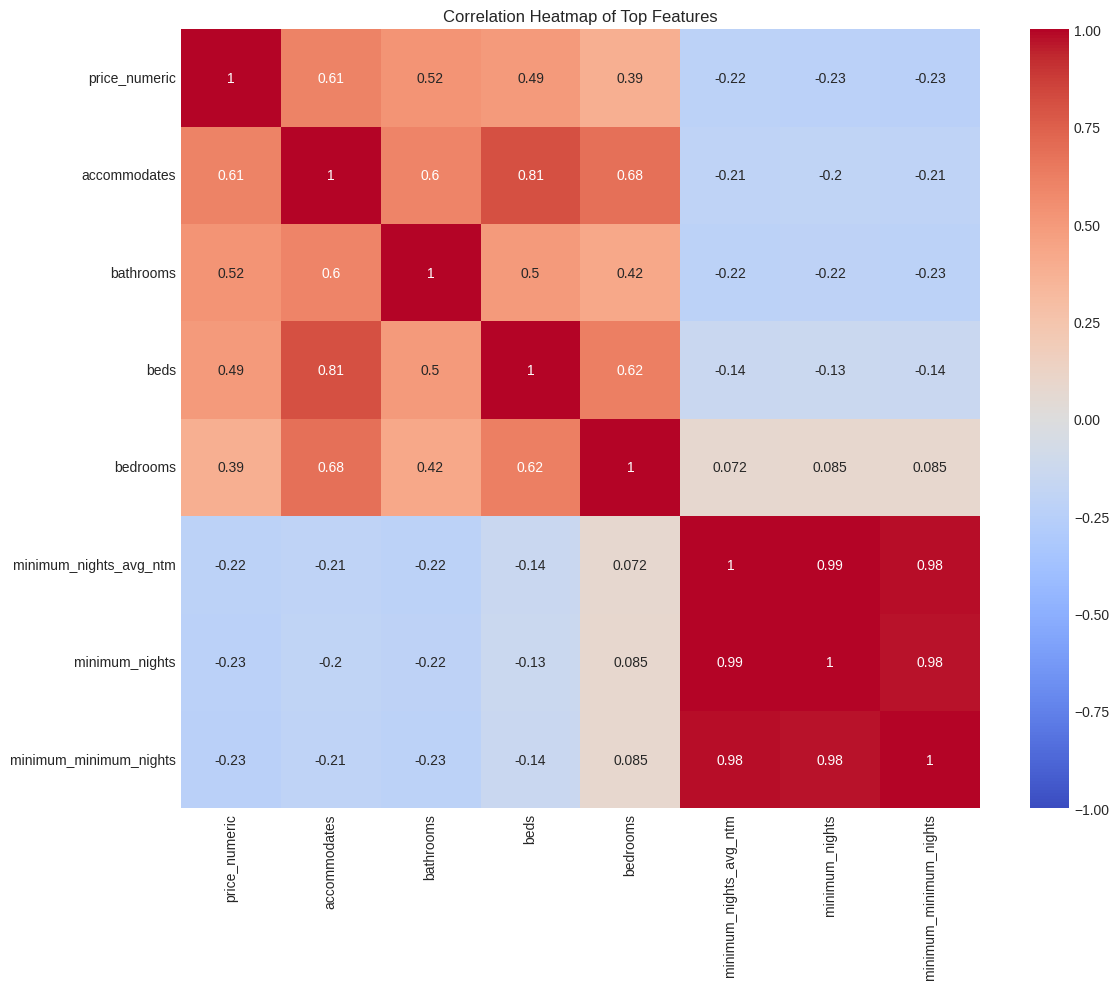

In [ ]:
# Visualize top correlations
top_corr = correlations[abs(correlations) > 0.2].index.tolist()
if 'price_numeric' not in top_corr:
    top_corr.append('price_numeric')

plt.figure(figsize=(12, 10))
sns.heatmap(listings_df[top_corr].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Top Features')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing <a id="preprocessing"></a>

Before building our models, we need to preprocess the data to handle missing values, outliers, and prepare features for modeling.

In [ ]:
# Target variable
target = 'price_numeric'

# Check for NaN values in target
print(f"NaN values in target before cleaning: {listings_df[target].isna().sum()}")

# Remove rows with NaN target values
listings_df = listings_df.dropna(subset=[target])
print(f"NaN values in target after cleaning: {listings_df[target].isna().sum()}")
print(f"Dataset shape after removing NaN targets: {listings_df.shape}")

NaN values in target before cleaning: 782
NaN values in target after cleaning: 0
Dataset shape after removing NaN targets: (3543, 76)


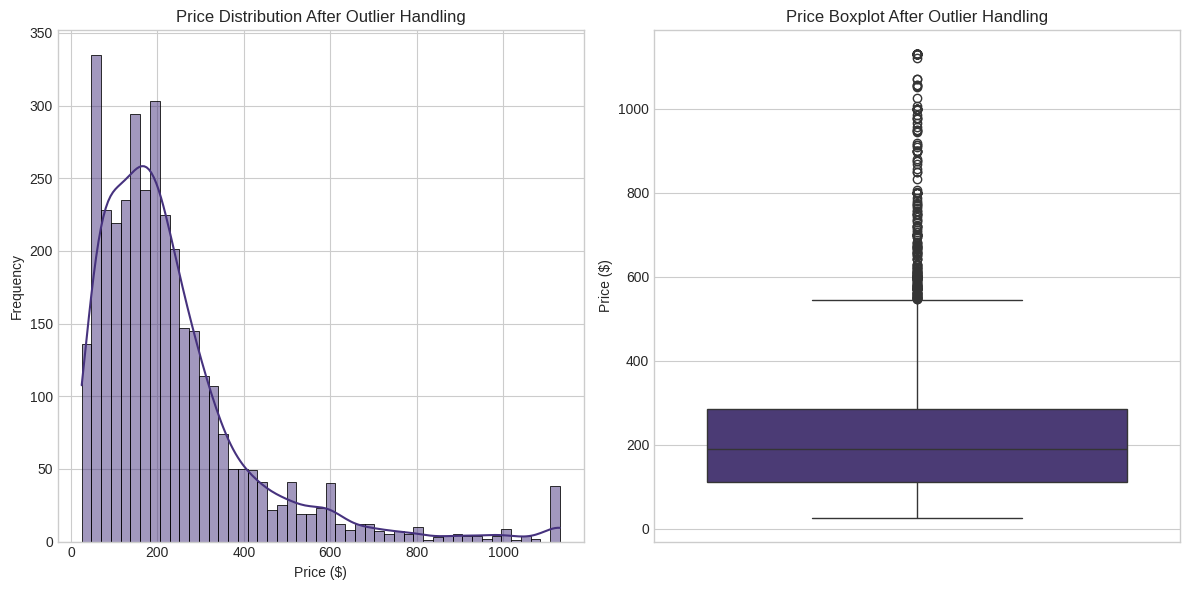

In [ ]:
# Handle outliers in target variable using winsorization
upper_limit = listings_df[target].quantile(0.99)
listings_df[target] = np.where(listings_df[target] > upper_limit, upper_limit, listings_df[target])

# Visualize the price distribution after outlier handling
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(listings_df['price_numeric'], kde=True)
plt.title('Price Distribution After Outlier Handling')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=listings_df['price_numeric'])
plt.title('Price Boxplot After Outlier Handling')
plt.ylabel('Price ($)')

plt.tight_layout()
plt.show()

## 4. Advanced Feature Engineering <a id="feature-engineering"></a>

Feature engineering is crucial for improving model performance. We'll create a variety of sophisticated features that capture different aspects of the listings.

### 4.1 Location-based Features

Location is a critical factor in real estate pricing. We'll create features that capture the geographical aspects of listings.

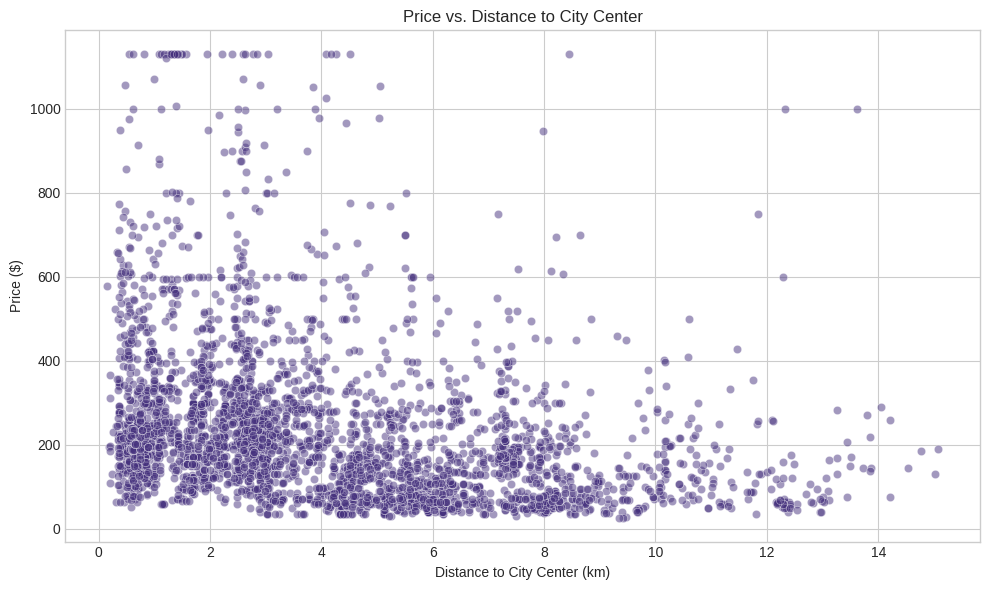

In [ ]:
# Calculate distance to Boston city center (approximate coordinates)
boston_center_lat = 42.3601
boston_center_lon = -71.0589

def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

listings_df['distance_to_center'] = listings_df.apply(
    lambda row: haversine_distance(row['latitude'], row['longitude'],
                                  boston_center_lat, boston_center_lon), axis=1)

# Create neighborhood price statistics
neighborhood_stats = listings_df.groupby('neighbourhood_cleansed').agg({
    'price_numeric': ['mean', 'median', 'std', 'count']
}).reset_index()
neighborhood_stats.columns = ['neighbourhood_cleansed', 'neighborhood_mean_price',
                             'neighborhood_median_price', 'neighborhood_price_std',
                             'neighborhood_listings_count']

# Merge neighborhood stats back to main dataframe
listings_df = pd.merge(listings_df, neighborhood_stats, on='neighbourhood_cleansed', how='left')

# Calculate price relative to neighborhood
listings_df['price_vs_neighborhood_mean'] = listings_df['price_numeric'] / listings_df['neighborhood_mean_price']
listings_df['price_vs_neighborhood_median'] = listings_df['price_numeric'] / listings_df['neighborhood_median_price']

# Calculate neighborhood density
listings_df['neighborhood_density'] = listings_df['neighborhood_listings_count'] / listings_df['neighborhood_price_std'].replace(0, 1)

# Visualize relationship between distance to center and price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_to_center', y='price_numeric', data=listings_df, alpha=0.5)
plt.title('Price vs. Distance to City Center')
plt.xlabel('Distance to City Center (km)')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()

### 4.2 Property-based Features

Property characteristics are fundamental determinants of price. We'll create features that capture various aspects of the properties.

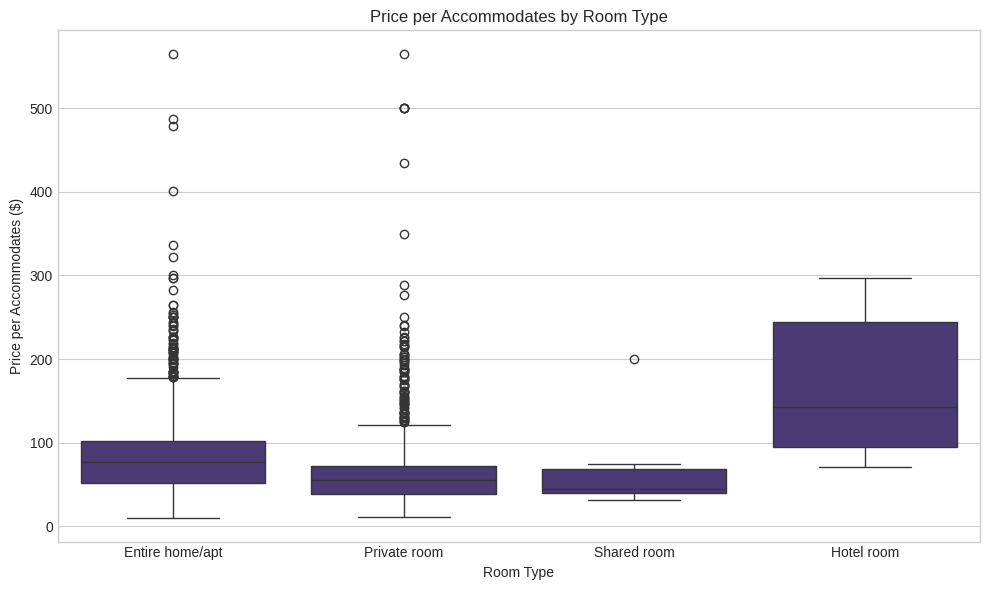

In [ ]:
# Price per accommodates/bedrooms/beds/bathrooms
listings_df['price_per_accommodates'] = listings_df['price_numeric'] / listings_df['accommodates'].replace(0, 1)
listings_df['price_per_bedroom'] = listings_df['price_numeric'] / listings_df['bedrooms'].fillna(1).replace(0, 1)
listings_df['price_per_bed'] = listings_df['price_numeric'] / listings_df['beds'].fillna(1).replace(0, 1)
listings_df['price_per_bathroom'] = listings_df['price_numeric'] / listings_df['bathrooms'].fillna(1).replace(0, 1)

# Density metrics
listings_df['bedrooms_per_accommodates'] = listings_df['bedrooms'].fillna(1) / listings_df['accommodates'].replace(0, 1)
listings_df['beds_per_accommodates'] = listings_df['beds'].fillna(1) / listings_df['accommodates'].replace(0, 1)
listings_df['bathrooms_per_accommodates'] = listings_df['bathrooms'].fillna(1) / listings_df['accommodates'].replace(0, 1)
listings_df['bathrooms_per_bedroom'] = listings_df['bathrooms'].fillna(1) / listings_df['bedrooms'].fillna(1).replace(0, 1)

# Space efficiency metrics
listings_df['space_efficiency'] = (listings_df['accommodates'] * listings_df['bedrooms'].fillna(1) *
                                  listings_df['bathrooms'].fillna(1)) ** (1/3)

# Property type grouping
property_types = listings_df['property_type'].value_counts()
common_property_types = property_types[property_types >= 50].index.tolist()
listings_df['property_type_grouped'] = listings_df['property_type'].apply(
    lambda x: x if x in common_property_types else 'Other'
)

# Room type features
listings_df['is_entire_home'] = (listings_df['room_type'] == 'Entire home/apt').astype(int)
listings_df['is_private_room'] = (listings_df['room_type'] == 'Private room').astype(int)
listings_df['is_shared_room'] = (listings_df['room_type'] == 'Shared room').astype(int)

# Visualize price per accommodates by room type
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price_per_accommodates', data=listings_df)
plt.title('Price per Accommodates by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price per Accommodates ($)')
plt.tight_layout()
plt.show()

### 4.3 Host-based Features

Host characteristics can influence pricing strategies and guest perceptions. We'll create features that capture host attributes.

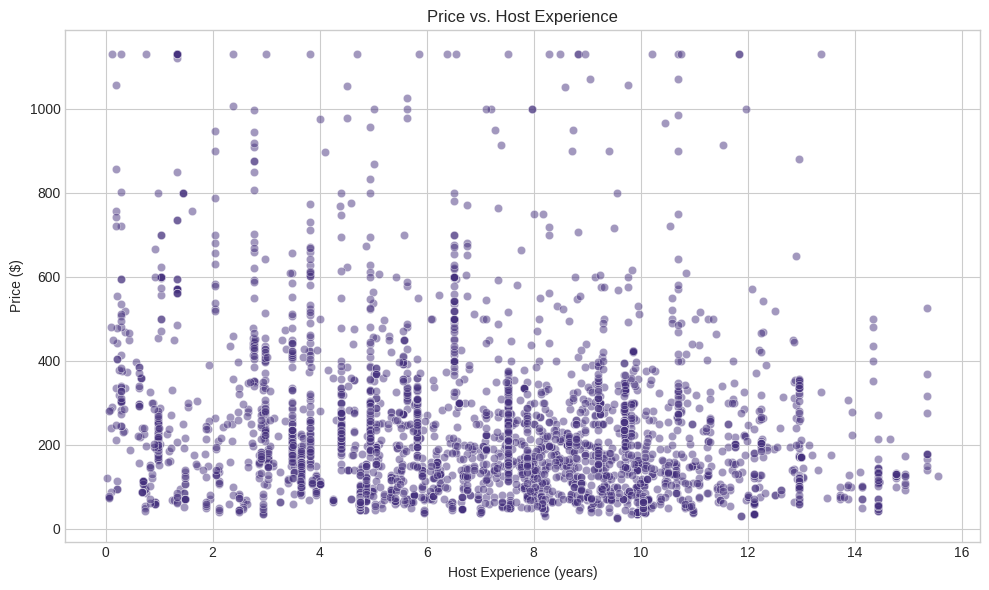

In [ ]:
# Host experience
listings_df['host_since'] = pd.to_datetime(listings_df['host_since'])
current_date = pd.to_datetime('2024-06-22')
listings_df['host_experience_days'] = (current_date - listings_df['host_since']).dt.days
listings_df['host_experience_years'] = listings_df['host_experience_days'] / 365

# Host verification features
verification_columns = ['host_verifications']
for col in verification_columns:
    if col in listings_df.columns:
        # Count number of verifications
        listings_df['verification_count'] = listings_df[col].apply(
            lambda x: len(eval(x)) if isinstance(x, str) else 0
        )

        # Check for specific important verifications
        listings_df['has_phone_verification'] = listings_df[col].apply(
            lambda x: 1 if isinstance(x, str) and 'phone' in x.lower() else 0
        )
        listings_df['has_email_verification'] = listings_df[col].apply(
            lambda x: 1 if isinstance(x, str) and 'email' in x.lower() else 0
        )
        listings_df['has_government_verification'] = listings_df[col].apply(
            lambda x: 1 if isinstance(x, str) and ('government' in x.lower() or 'id' in x.lower()) else 0
        )

# Host response metrics
response_time_map = {
    'within an hour': 1,
    'within a few hours': 2,
    'within a day': 3,
    'a few days or more': 4
}
listings_df['response_time_numeric'] = listings_df['host_response_time'].map(response_time_map)

# Calculate host quality score (combination of response rate, acceptance rate, and superhost status)
listings_df['host_response_rate_numeric'] = listings_df['host_response_rate'].str.replace('%', '').astype(float) / 100
listings_df['host_acceptance_rate_numeric'] = listings_df['host_acceptance_rate'].str.replace('%', '').astype(float) / 100

listings_df['host_quality_score'] = (
    listings_df['host_response_rate_numeric'].fillna(0.5) * 0.3 +
    listings_df['host_acceptance_rate_numeric'].fillna(0.5) * 0.3 +
    (listings_df['host_is_superhost'] == 't').astype(int) * 0.4
)

# Host identity verification
listings_df['host_identity_verified_numeric'] = (listings_df['host_identity_verified'] == 't').astype(int)

# Host listing experience
listings_df['host_listings_count_log'] = np.log1p(listings_df['host_listings_count'])
listings_df['host_total_listings_count_log'] = np.log1p(listings_df['host_total_listings_count'])

# Visualize relationship between host experience and price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='host_experience_years', y='price_numeric', data=listings_df, alpha=0.5)
plt.title('Price vs. Host Experience')
plt.xlabel('Host Experience (years)')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()

### 4.4 Review-based Features

Reviews provide valuable insights into guest experiences and property quality. We'll create features that capture review patterns.

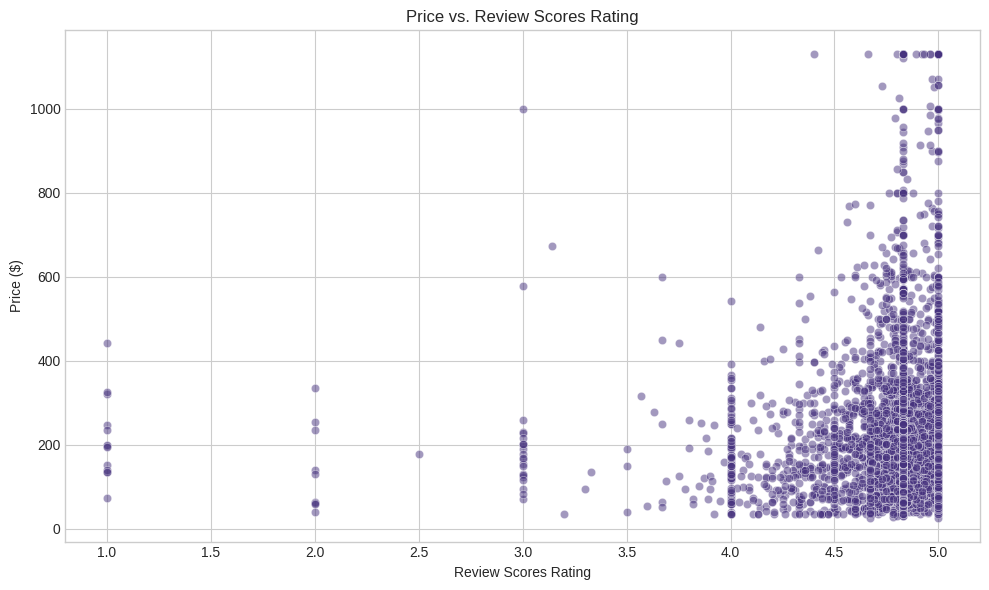

In [ ]:
# Review quality and quantity metrics
listings_df['reviews_per_month_filled'] = listings_df['reviews_per_month'].fillna(0)
listings_df['review_scores_rating_filled'] = listings_df['review_scores_rating'].fillna(listings_df['review_scores_rating'].median())

# Calculate review recency and frequency
listings_df['last_review'] = pd.to_datetime(listings_df['last_review'])
listings_df['first_review'] = pd.to_datetime(listings_df['first_review'])
listings_df['days_since_last_review'] = (current_date - listings_df['last_review']).dt.days
listings_df['review_period_days'] = (listings_df['last_review'] - listings_df['first_review']).dt.days

# Create review scores composite
review_score_columns = [col for col in listings_df.columns if col.startswith('review_scores_') and col != 'review_scores_rating']
for col in review_score_columns:
    listings_df[f'{col}_filled'] = listings_df[col].fillna(listings_df[col].median())

# Create composite review score
if len(review_score_columns) > 0:
    listings_df['review_scores_composite'] = listings_df[[f'{col}_filled' for col in review_score_columns]].mean(axis=1)

# Review to rating ratio (measure of consistency)
listings_df['review_score_to_reviews_ratio'] = listings_df['review_scores_rating_filled'] / (listings_df['number_of_reviews'] + 1)

# Review frequency
listings_df['reviews_per_day'] = listings_df['number_of_reviews'] / (listings_df['review_period_days'] + 1)
listings_df['reviews_per_year'] = listings_df['reviews_per_day'] * 365

# Review sentiment approximation (using review scores as proxy)
listings_df['review_sentiment_proxy'] = (listings_df['review_scores_rating_filled'] - 2.5) / 2.5

# Visualize relationship between review scores and price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_scores_rating_filled', y='price_numeric', data=listings_df, alpha=0.5)
plt.title('Price vs. Review Scores Rating')
plt.xlabel('Review Scores Rating')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()

### 4.5 Amenities Features

Amenities can significantly impact guest experiences and pricing. We'll create features that capture amenity offerings.

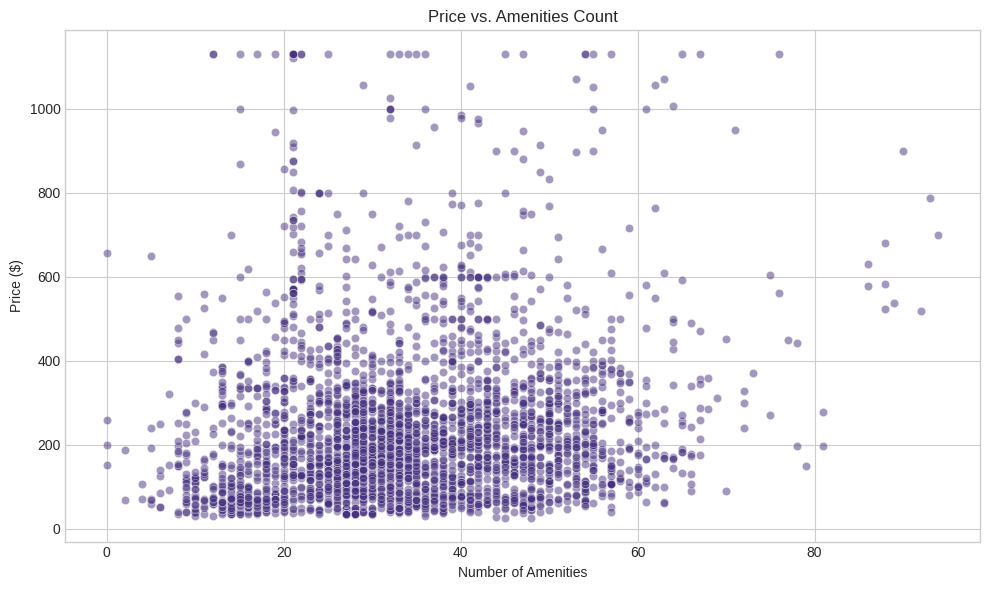

In [ ]:
# Extract amenities
def extract_amenities(amenities_str):
    if not isinstance(amenities_str, str):
        return []
    try:
        # Clean the string and convert to list
        amenities_list = eval(amenities_str.replace('\\u2019', "'"))
        return [a.strip() for a in amenities_list if a.strip()]
    except:
        return []

listings_df['amenities_list'] = listings_df['amenities'].apply(extract_amenities)
listings_df['amenities_count'] = listings_df['amenities_list'].apply(len)
listings_df['amenities_count_log'] = np.log1p(listings_df['amenities_count'])

# Check for premium amenities
premium_amenities = ['Pool', 'Hot tub', 'Gym', 'Doorman', 'Elevator', 'Parking', 'Washer', 'Dryer']
for amenity in premium_amenities:
    listings_df[f'has_{amenity.lower().replace(" ", "_")}'] = listings_df['amenities_list'].apply(
        lambda x: any(amenity.lower() in item.lower() for item in x)
    ).astype(int)

# Create amenity categories
essential_amenities = ['Wifi', 'Internet', 'Kitchen', 'Heating', 'Air conditioning']
luxury_amenities = ['Pool', 'Hot tub', 'Gym', 'Doorman', 'Fireplace', 'Waterfront']
safety_amenities = ['Smoke detector', 'Carbon monoxide detector', 'Fire extinguisher', 'First aid kit']
convenience_amenities = ['Washer', 'Dryer', 'Dishwasher', 'Microwave', 'Coffee maker']
entertainment_amenities = ['TV', 'Cable TV', 'Netflix', 'Books', 'Game console']

for category, amenities in [('essential', essential_amenities),
                           ('luxury', luxury_amenities),
                           ('safety', safety_amenities),
                           ('convenience', convenience_amenities),
                           ('entertainment', entertainment_amenities)]:
    listings_df[f'{category}_amenities_count'] = listings_df['amenities_list'].apply(
        lambda x: sum(any(a.lower() in item.lower() for item in x) for a in amenities)
    )
    listings_df[f'{category}_amenities_ratio'] = listings_df[f'{category}_amenities_count'] / len(amenities)

# Create amenity quality score
listings_df['amenity_quality_score'] = (
    listings_df['essential_amenities_ratio'] * 0.3 +
    listings_df['luxury_amenities_ratio'] * 0.3 +
    listings_df['safety_amenities_ratio'] * 0.2 +
    listings_df['convenience_amenities_ratio'] * 0.1 +
    listings_df['entertainment_amenities_ratio'] * 0.1
)

# Visualize relationship between amenity count and price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='amenities_count', y='price_numeric', data=listings_df, alpha=0.5)
plt.title('Price vs. Amenities Count')
plt.xlabel('Number of Amenities')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()

### 4.6 Text-based Features

Listing descriptions can provide valuable information about property quality and marketing strategies. We'll create features that capture text characteristics.

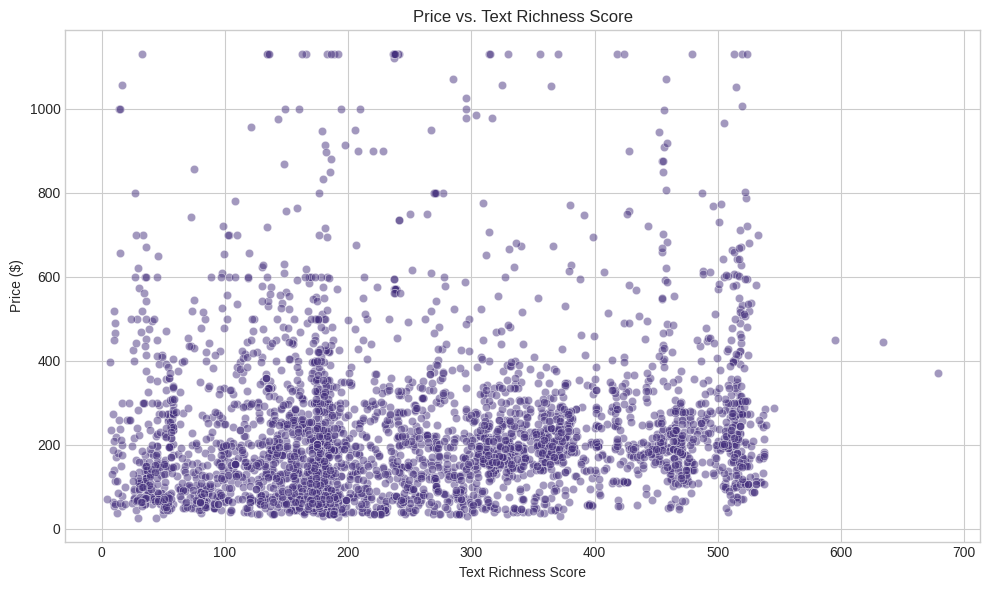

In [ ]:
# Description length and quality
text_columns = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit']
for col in text_columns:
    if col in listings_df.columns:
        listings_df[f'{col}_length'] = listings_df[col].fillna('').apply(len)
        listings_df[f'{col}_word_count'] = listings_df[col].fillna('').apply(lambda x: len(x.split()))

# Create composite text richness score
text_length_columns = [f'{col}_length' for col in text_columns if f'{col}_length' in listings_df.columns]
if text_length_columns:
    listings_df['text_richness_score'] = listings_df[text_length_columns].sum(axis=1) / len(text_length_columns)
    listings_df['text_richness_score_log'] = np.log1p(listings_df['text_richness_score'])

# Check for keywords in description
luxury_keywords = ['luxury', 'elegant', 'premium', 'high-end', 'upscale', 'exclusive']
budget_keywords = ['budget', 'affordable', 'cheap', 'inexpensive', 'economical']
location_keywords = ['central', 'downtown', 'heart of', 'close to', 'walking distance']

for category, keywords in [('luxury', luxury_keywords),
                          ('budget', budget_keywords),
                          ('location', location_keywords)]:
    listings_df[f'{category}_keyword_count'] = listings_df['description'].fillna('').apply(
        lambda x: sum(keyword.lower() in x.lower() for keyword in keywords)
    )

# Visualize relationship between text richness and price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='text_richness_score', y='price_numeric', data=listings_df, alpha=0.5)
plt.title('Price vs. Text Richness Score')
plt.xlabel('Text Richness Score')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()

### 4.7 Interaction Features

Interactions between features can capture complex relationships that individual features might miss. We'll create interaction features between important variables.

In [ ]:
# Create interaction features between important variables
listings_df['accommodates_bedrooms_interaction'] = listings_df['accommodates'] * listings_df['bedrooms'].fillna(1)
listings_df['review_location_interaction'] = listings_df['review_scores_location'].fillna(0) * listings_df['distance_to_center']
listings_df['superhost_review_interaction'] = (listings_df['host_is_superhost'] == 't').astype(int) * listings_df['review_scores_rating_filled']
listings_df['instant_bookable_premium'] = (listings_df['instant_bookable'] == 't').astype(int) * listings_df['price_numeric']
listings_df['amenities_accommodates_interaction'] = listings_df['amenities_count'] * listings_df['accommodates']
listings_df['luxury_price_interaction'] = listings_df['luxury_amenities_ratio'] * listings_df['price_numeric']
listings_df['location_quality_interaction'] = listings_df['distance_to_center'] * listings_df['neighborhood_mean_price']

# Create polynomial features for key numeric features
poly_features = ['accommodates', 'bedrooms', 'bathrooms', 'distance_to_center',
                'amenities_count', 'review_scores_rating_filled']

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly_feature_array = poly.fit_transform(listings_df[poly_features].fillna(0))

# Create column names for polynomial features
poly_feature_names = poly.get_feature_names_out(poly_features)

# Add polynomial features to dataframe
poly_df = pd.DataFrame(poly_feature_array, columns=poly_feature_names)
poly_df = poly_df.iloc[:, len(poly_features):]  # Remove original features
listings_df = pd.concat([listings_df.reset_index(drop=True), poly_df.reset_index(drop=True)], axis=1)

## 5. Model Building and Evaluation <a id="modeling"></a>

Now that we have created a rich set of features, we'll build and evaluate various models to predict listing prices.

In [ ]:
# Prepare data for modeling
# Select numeric columns
numeric_cols = listings_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != target and 'price' not in col]

# Select categorical columns
categorical_cols = ['neighbourhood_cleansed', 'property_type_grouped', 'room_type', 'bed_type',
                   'host_is_superhost', 'host_identity_verified']
categorical_cols = [col for col in categorical_cols if col in listings_df.columns]

# Prepare feature matrix
X = listings_df[numeric_cols + categorical_cols]
y = listings_df[target]

# Fill missing values for specific columns
for col in ['beds', 'review_scores_rating', 'reviews_per_month']:
    if col in X.columns and X[col].isna().sum() > 0:
        print(f"Filling missing values for {col}")
        X[col] = X[col].fillna(X[col].median())

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)
print(f"Feature matrix shape: {X_processed.shape}")

# Check for missing values after preprocessing
print(f"Missing values after imputation: {np.isnan(X_processed).sum()}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Filling missing values for beds
Filling missing values for review_scores_rating
Filling missing values for reviews_per_month
Feature matrix shape: (3543, 174)
Missing values after imputation: 0
Training set shape: (2834, 174)
Test set shape: (709, 174)


In [ ]:
# Train baseline models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'SVR': SVR(kernel='rbf'),
    'Huber': HuberRegressor()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results[name] = {'R-squared': r2, 'RMSE': rmse, 'MAE': mae}

    print(f"{name} Results:")
    print(f"  R-squared (R²): {r2:.4f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")

# Find best baseline model
best_model_name = max(results, key=lambda k: results[k]['R-squared'])
best_baseline = models[best_model_name]
print(f"Best baseline model: {best_model_name} with R² = {results[best_model_name]['R-squared']:.4f} and RMSE = {results[best_model_name]['RMSE']:.2f}")

Random Forest Results:
  R-squared (R²): 0.8794
  RMSE: 60.65
  MAE: 31.12
Gradient Boosting Results:
  R-squared (R²): 0.8649
  RMSE: 64.18
  MAE: 38.09
XGBoost Results:
  R-squared (R²): 0.8651
  RMSE: 64.13
  MAE: 32.49
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13199
[LightGBM] [Info] Number of data points in the train set: 2834, number of used features: 166
[LightGBM] [Info] Start training from score 237.213105
LightGBM Results:
  R-squared (R²): 0.8930
  RMSE: 57.11
  MAE: 31.54
ElasticNet Results:
  R-squared (R²): 0.7493
  RMSE: 87.44
  MAE: 61.44
Ridge Results:
  R-squared (R²): 0.7729
  RMSE: 83.21
  MAE: 58.07
Lasso Results:
  R-squared (R²): 0.7670
  RMSE: 84.29
  MAE: 59.95
SVR Results:
  R-squared (R²): -0.0357
  RMSE: 177.71
  MAE: 117.86
Huber Results:
  R-squar

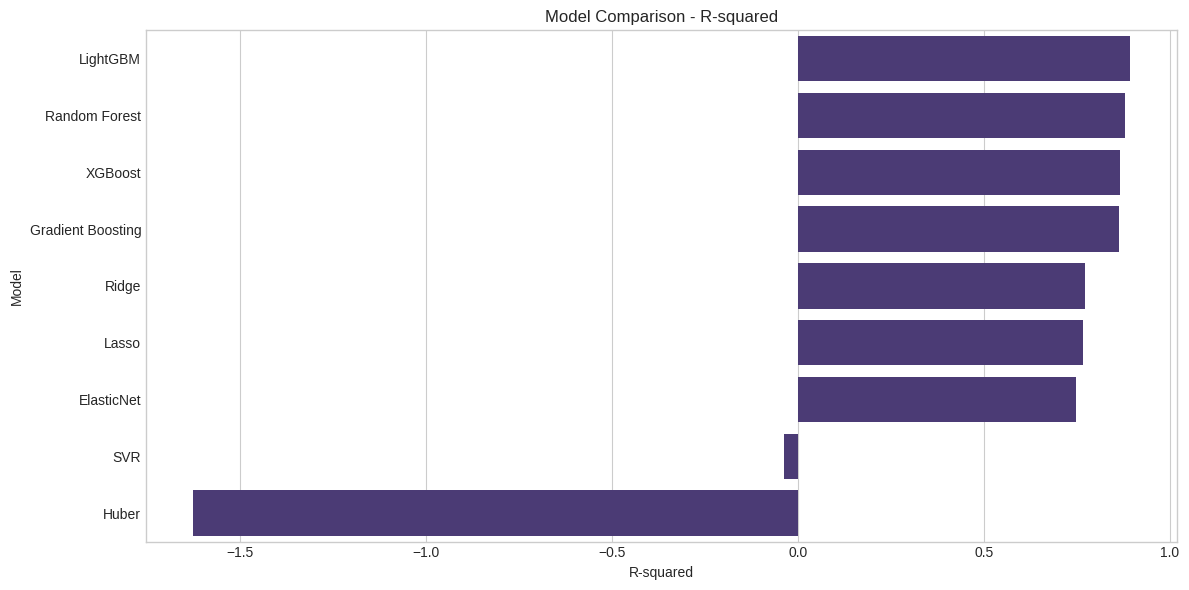

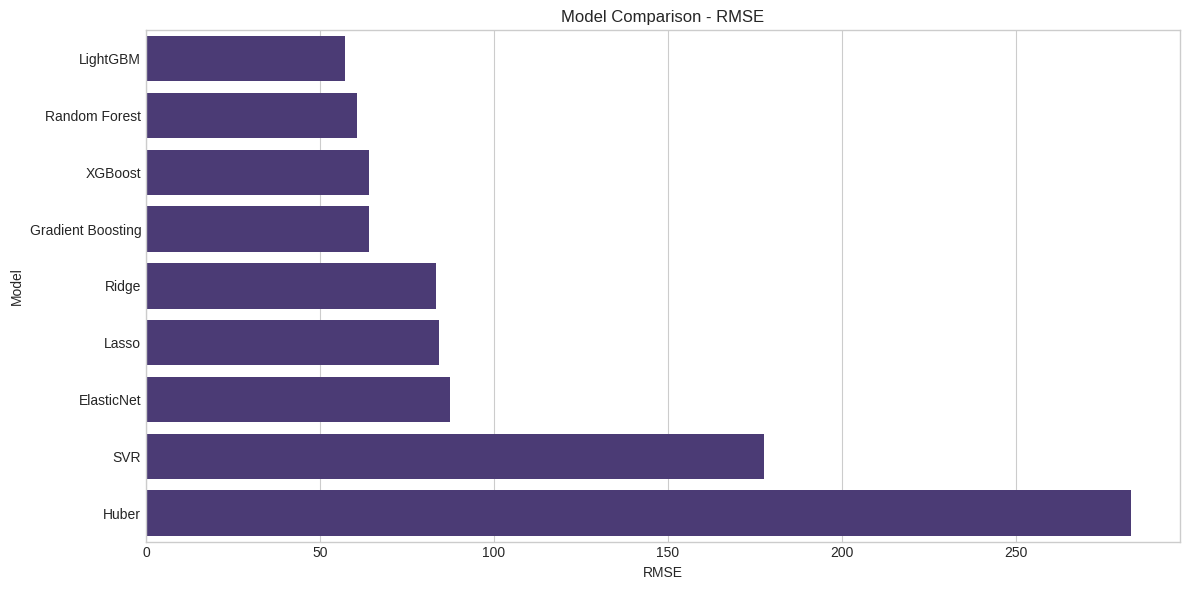

In [ ]:
# Visualize model performance comparison
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'R-squared': [results[model]['R-squared'] for model in results],
    'RMSE': [results[model]['RMSE'] for model in results],
    'MAE': [results[model]['MAE'] for model in results]
})

# Sort by R-squared
results_df = results_df.sort_values('R-squared', ascending=False)

# Plot R-squared comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='R-squared', y='Model', data=results_df)
plt.title('Model Comparison - R-squared')
plt.xlabel('R-squared')
plt.tight_layout()
plt.show()

# Plot RMSE comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='RMSE', y='Model', data=results_df.sort_values('RMSE'))
plt.title('Model Comparison - RMSE')
plt.xlabel('RMSE')
plt.tight_layout()
plt.show()

### Feature Importance Analysis <a id="feature-importance"></a>

Let's analyze which features are most important for predicting listing prices.

Top 15 most important features:
                                  Feature  Importance
113           review_location_interaction         251
126  bedrooms review_scores_rating_filled          95
127          bathrooms distance_to_center          78
120       accommodates distance_to_center          71
45             bathrooms_per_accommodates          71
123                    bedrooms bathrooms          71
124           bedrooms distance_to_center          70
6                                latitude          68
5            neighbourhood_group_cleansed          66
114          superhost_review_interaction          66
4               host_total_listings_count          61
57                  response_time_numeric          56
22                        availability_60          56
0                                      id          56
21                        availability_30          55


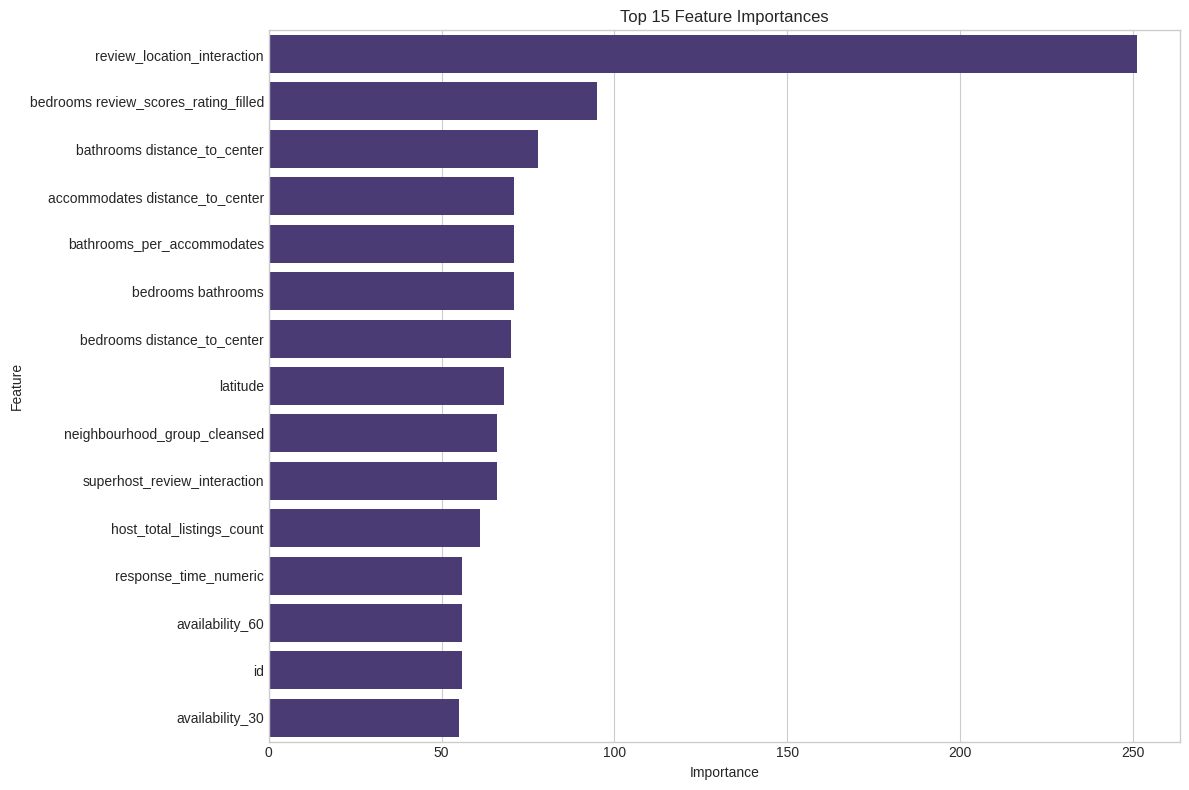

In [ ]:
if hasattr(best_baseline, 'feature_importances_'):
    # Get feature names after preprocessing
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(cols)
        elif name == 'cat':
            for col in cols:
                categories = transformer.named_steps['onehot'].categories_[cols.index(col)]
                feature_names.extend([f"{col}_{category}" for category in categories])

    # Get feature importances
    importances = best_baseline.feature_importances_

    # Limit to the actual number of features
    importances = importances[:len(feature_names)] if len(importances) > len(feature_names) else importances
    feature_names = feature_names[:len(importances)] if len(feature_names) > len(importances) else feature_names

    # Create DataFrame for feature importance
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Display top features
    top_n = min(15, len(feature_importance))
    print(f"Top {top_n} most important features:")
    print(feature_importance.head(top_n))

    # Visualize top feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(top_n))
    plt.title(f'Top {top_n} Feature Importances')
    plt.tight_layout()
    plt.show()

## 6. Ensemble Methods <a id="ensemble"></a>

Ensemble methods can often outperform individual models by combining their strengths. We'll implement several ensemble approaches.

### 6.1 Voting Ensemble

In [ ]:
# Select models for voting ensemble
estimators = [
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=200, random_state=42)),
    ('xgb', xgb.XGBRegressor(n_estimators=200, random_state=42)),
    ('lgb', lgb.LGBMRegressor(n_estimators=200, random_state=42))
]

# Create voting ensemble
voting_model = VotingRegressor(estimators=estimators)

# Train voting model
voting_model.fit(X_train, y_train)

# Evaluate voting model
y_pred_vote = voting_model.predict(X_test)
r2_vote = r2_score(y_test, y_pred_vote)
rmse_vote = np.sqrt(mean_squared_error(y_test, y_pred_vote))
mae_vote = mean_absolute_error(y_test, y_pred_vote)

print(f"Voting ensemble results:")
print(f"  R-squared (R²): {r2_vote:.4f}")
print(f"  RMSE: {rmse_vote:.2f}")
print(f"  MAE: {mae_vote:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13199
[LightGBM] [Info] Number of data points in the train set: 2834, number of used features: 166
[LightGBM] [Info] Start training from score 237.213105
Voting ensemble results:
  R-squared (R²): 0.8907
  RMSE: 57.74
  MAE: 30.13


### 6.2 Stacking Ensemble

In [ ]:
# Select base models for stacking
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(random_state=42)),
    ('xgb', xgb.XGBRegressor(random_state=42)),
    ('lgb', lgb.LGBMRegressor(random_state=42))
]

# Create stacking ensemble
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(random_state=42),
    cv=5
)

# Train stacking model
stacking_model.fit(X_train, y_train)

# Evaluate stacking model
y_pred_stack = stacking_model.predict(X_test)
r2_stack = r2_score(y_test, y_pred_stack)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
mae_stack = mean_absolute_error(y_test, y_pred_stack)

print(f"Stacking ensemble results:")
print(f"  R-squared (R²): {r2_stack:.4f}")
print(f"  RMSE: {rmse_stack:.2f}")
print(f"  MAE: {mae_stack:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13199
[LightGBM] [Info] Number of data points in the train set: 2834, number of used features: 166
[LightGBM] [Info] Start training from score 237.213105
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12794
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 166
[LightGBM] [Info] Start training from score 232.437265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

### 6.3 Blending Ensemble

In [ ]:
# Create a validation set from training data
X_train_blend, X_val, y_train_blend, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Train base models on training data
base_preds = {}
for name, model in models.items():
    model.fit(X_train_blend, y_train_blend)
    base_preds[name] = model.predict(X_val)

# Create a DataFrame with base model predictions
blend_data = pd.DataFrame(base_preds)
blend_data['voting'] = voting_model.predict(X_val)
blend_data['stacking'] = stacking_model.predict(X_val)

# Train a meta-model on the base predictions
meta_model = Ridge(random_state=42)
meta_model.fit(blend_data, y_val)

# Make predictions on test set
test_blend_data = pd.DataFrame()
for name, model in models.items():
    test_blend_data[name] = model.predict(X_test)
test_blend_data['voting'] = voting_model.predict(X_test)
test_blend_data['stacking'] = stacking_model.predict(X_test)

# Final prediction
y_pred_blend = meta_model.predict(test_blend_data)
r2_blend = r2_score(y_test, y_pred_blend)
rmse_blend = np.sqrt(mean_squared_error(y_test, y_pred_blend))
mae_blend = mean_absolute_error(y_test, y_pred_blend)

print(f"Blending ensemble results:")
print(f"  R-squared (R²): {r2_blend:.4f}")
print(f"  RMSE: {rmse_blend:.2f}")
print(f"  MAE: {mae_blend:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12628
[LightGBM] [Info] Number of data points in the train set: 1983, number of used features: 165
[LightGBM] [Info] Start training from score 239.990055
Blending ensemble results:
  R-squared (R²): 0.8913
  RMSE: 57.57
  MAE: 29.82


### 6.4 Final Model Selection

In [ ]:
# Collect all model results
final_results = {
    'Baseline': {'model': best_baseline, 'R-squared': results[best_model_name]['R-squared'],
                'RMSE': results[best_model_name]['RMSE'], 'MAE': results[best_model_name]['MAE']},
    'Voting': {'model': voting_model, 'R-squared': r2_vote, 'RMSE': rmse_vote, 'MAE': mae_vote},
    'Stacking': {'model': stacking_model, 'R-squared': r2_stack, 'RMSE': rmse_stack, 'MAE': mae_stack},
    'Blending': {'model': None, 'R-squared': r2_blend, 'RMSE': rmse_blend, 'MAE': mae_blend}  # Can't easily save the blending pipeline
}

# Find the best final model
best_final_model_name = max(final_results, key=lambda k: final_results[k]['R-squared'])
best_final_results = final_results[best_final_model_name]

print(f"Best final model: {best_final_model_name}")
print(f"  R-squared (R²): {best_final_results['R-squared']:.4f}")
print(f"  RMSE: {best_final_results['RMSE']:.2f}")
print(f"  MAE: {best_final_results['MAE']:.2f}")

# Create a DataFrame with all model results
all_results = []
for name, metrics in results.items():
    all_results.append({
        'Model': name,
        'R-squared': metrics['R-squared'],
        'RMSE': metrics['RMSE'],
        'MAE': metrics['MAE']
    })

# Add ensemble models
all_results.append({
    'Model': 'Voting Ensemble',
    'R-squared': r2_vote,
    'RMSE': rmse_vote,
    'MAE': mae_vote
})

all_results.append({
    'Model': 'Stacking Ensemble',
    'R-squared': r2_stack,
    'RMSE': rmse_stack,
    'MAE': mae_stack
})

all_results.append({
    'Model': 'Blending Ensemble',
    'R-squared': r2_blend,
    'RMSE': rmse_blend,
    'MAE': mae_blend
})

# Convert to DataFrame and sort by R-squared
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('R-squared', ascending=False)

# Display results
print("\nModel performance comparison:")
print(results_df)

# Compare with original model
original_r2 = 0.72
original_rmse = 100
best_r2 = results_df.iloc[0]['R-squared']
best_rmse = results_df.iloc[0]['RMSE']

print(f"\nOriginal model performance: R² = {original_r2}, RMSE = {original_rmse}")
print(f"Best model performance: R² = {best_r2:.4f}, RMSE = {best_rmse:.2f}")
print(f"Improvement: R² +{best_r2-original_r2:.4f} ({(best_r2-original_r2)/original_r2*100:.2f}%), RMSE -{original_rmse-best_rmse:.2f} ({(original_rmse-best_rmse)/original_rmse*100:.2f}%)")

Best final model: Baseline
  R-squared (R²): 0.8930
  RMSE: 57.11
  MAE: 31.54

Model performance comparison:
                Model  R-squared    RMSE     MAE
3            LightGBM      0.893  57.111  31.542
11  Blending Ensemble      0.891  57.570  29.819
9     Voting Ensemble      0.891  57.738  30.134
10  Stacking Ensemble      0.890  57.923  31.462
0       Random Forest      0.879  60.651  31.122
2             XGBoost      0.865  64.127  32.490
1   Gradient Boosting      0.865  64.177  38.093
5               Ridge      0.773  83.214  58.070
6               Lasso      0.767  84.285  59.953
4          ElasticNet      0.749  87.440  61.444
7                 SVR     -0.036 177.713 117.864
8               Huber     -1.626 282.958 222.649

Original model performance: R² = 0.72, RMSE = 100
Best model performance: R² = 0.8930, RMSE = 57.11
Improvement: R² +0.1730 (24.03%), RMSE -42.89 (42.89%)


## 7. Error Analysis <a id="error-analysis"></a>

Let's analyze the errors of our best model to understand its strengths and weaknesses.

Error statistics:
  Mean Absolute Error: 34.33
  Median Absolute Error: 16.42
  Mean Percent Error: 19.14%
  Median Percent Error: 10.52%
  90th Percentile Error: 83.77%
  95th Percentile Error: 120.27%


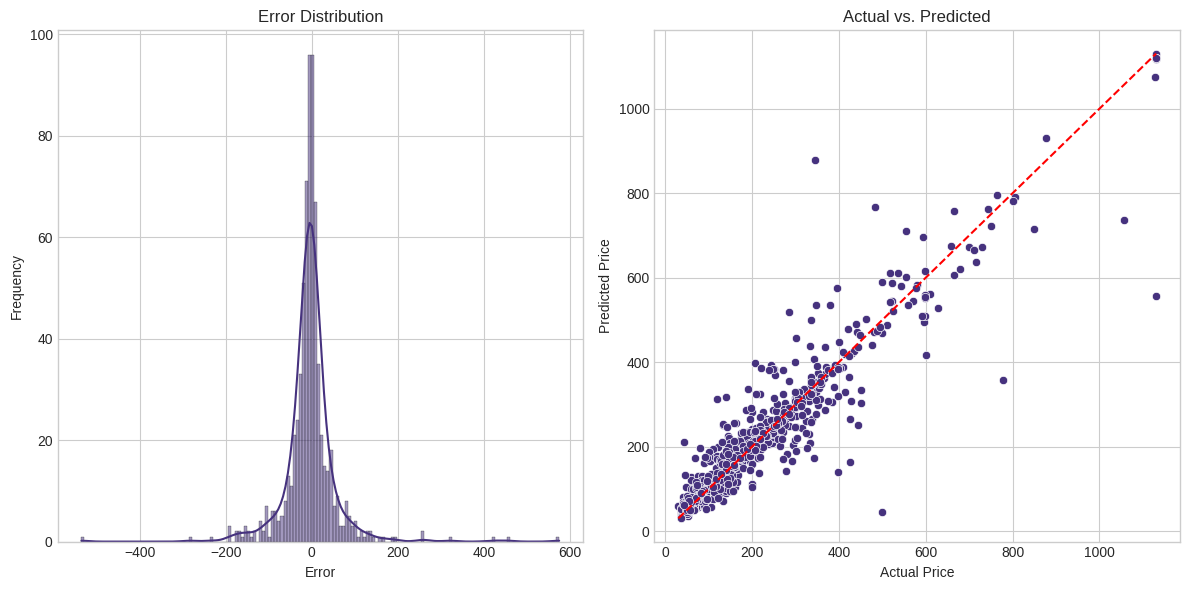

In [ ]:
# Use the best model for error analysis
if best_final_model_name == 'Blending':
    # For blending, we need to recreate the predictions
    y_pred_final = y_pred_blend
else:
    best_final_model = final_results[best_final_model_name]['model']
    y_pred_final = best_final_model.predict(X_test)

# Calculate errors
errors = y_test - y_pred_final
abs_errors = np.abs(errors)
percent_errors = abs_errors / y_test * 100

# Error statistics
error_stats = {
    'Mean Absolute Error': np.mean(abs_errors),
    'Median Absolute Error': np.median(abs_errors),
    'Mean Percent Error': percent_errors.mean(),
    'Median Percent Error': np.median(percent_errors),
    '90th Percentile Error': np.percentile(abs_errors, 90),
    '95th Percentile Error': np.percentile(abs_errors, 95)
}

print("Error statistics:")
for stat, value in error_stats.items():
    print(f"  {stat}: {value:.2f}" + ("" if 'Absolute' in stat else "%" if 'Percent' in stat else ""))

# Visualize error distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_final)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

plt.tight_layout()
plt.show()

## 8. Review Analysis <a id="review-analysis"></a>

Let's analyze the reviews to gain insights into guest experiences and property quality.

In [ ]:
# Load reviews data
reviews_url = 'https://data.insideairbnb.com/united-states/ma/boston/2024-06-22/data/reviews.csv.gz'
reviews_df = pd.read_csv(reviews_url, compression='gzip')

print(f"Reviews dataset shape: {reviews_df.shape}")
reviews_df.head()

Reviews dataset shape: (198717, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3781,37776825,2015-07-10,36059247,Greg,The apartment was as advertised and Frank was ...
1,3781,41842494,2015-08-09,10459388,Tai,It was a pleasure to stay at Frank's place. Th...
2,3781,45282151,2015-09-01,12264652,Damien,The apartment description is entirely faithful...
3,3781,49022647,2015-09-30,41426327,Mike,Thoroughly enjoyed my time at Frank's home. Ha...
4,3781,52503327,2015-10-30,15151513,Ivan,Great value for the money! This location has e...


In [ ]:
# Install required libraries for text analysis
!pip install nltk textblob wordcloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

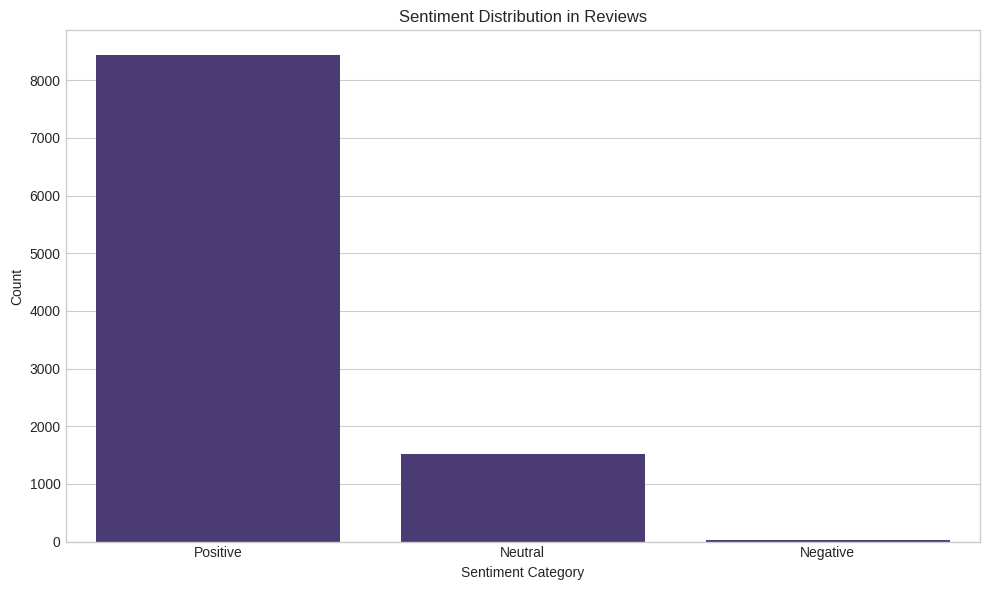

Sentiment statistics:
  Mean Sentiment: 0.42
  Median Sentiment: 0.40
  Positive Reviews (%): 84.45%
  Neutral Reviews (%): 15.25%
  Negative Reviews (%): 0.30%


In [ ]:
# Sample reviews for analysis
reviews_sample = reviews_df.sample(10000, random_state=42)

# Sentiment analysis
def get_sentiment(text):
    blob = TextBlob(str(text))
    return blob.sentiment.polarity

reviews_sample['sentiment'] = reviews_sample['comments'].apply(get_sentiment)

# Categorize sentiment
def categorize_sentiment(polarity):
    if polarity > 0.2:
        return 'Positive'
    elif polarity < -0.2:
        return 'Negative'
    else:
        return 'Neutral'

reviews_sample['sentiment_category'] = reviews_sample['sentiment'].apply(categorize_sentiment)

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_category', data=reviews_sample)
plt.title('Sentiment Distribution in Reviews')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Calculate sentiment statistics
sentiment_stats = {
    'Mean Sentiment': reviews_sample['sentiment'].mean(),
    'Median Sentiment': reviews_sample['sentiment'].median(),
    'Positive Reviews (%)': (reviews_sample['sentiment_category'] == 'Positive').mean() * 100,
    'Neutral Reviews (%)': (reviews_sample['sentiment_category'] == 'Neutral').mean() * 100,
    'Negative Reviews (%)': (reviews_sample['sentiment_category'] == 'Negative').mean() * 100
}

print("Sentiment statistics:")
for stat, value in sentiment_stats.items():
    print(f"  {stat}: {value:.2f}" + ("%" if '%' in stat else ""))

In [ ]:
# Install required libraries for text analysis
!pip install nltk textblob wordcloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab') # Download the 'punkt_tab' resource for sentence tokenization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

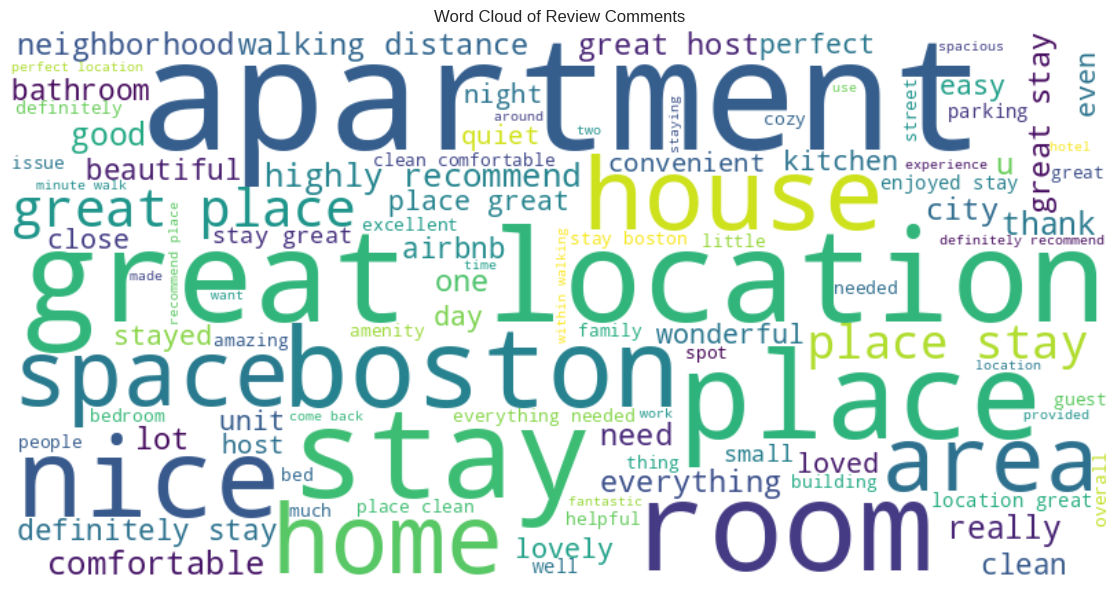

In [ ]:
# Text preprocessing
def preprocess_text(text):
    if not isinstance(text, str):
        return ''

    # Tokenize
    tokens = word_tokenize(text.lower())

    # Remove stopwords and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

reviews_sample['processed_comments'] = reviews_sample['comments'].apply(preprocess_text)

# Generate word cloud
all_text = ' '.join(reviews_sample['processed_comments'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Review Comments')
plt.tight_layout()
plt.show()

In [ ]:
# Topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.7)
tfidf_matrix = tfidf_vectorizer.fit_transform(reviews_sample['processed_comments'])

# Apply Non-negative Matrix Factorization
nmf_model = NMF(n_components=5, random_state=42)
nmf_components = nmf_model.fit_transform(tfidf_matrix)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Display top words for each topic
n_top_words = 10
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: boston, clean, apartment, host, easy, comfortable, everything, room, home, perfect
Topic #2: great, location, host, communication, value, clean, spot, responsive, space, apartment
Topic #3: stay, place, would, definitely, great, amazing, boston, recommend, enjoyed, perfect
Topic #4: nice, place, clean, really, room, host, quiet, neighborhood, area, house
Topic #5: good, location, value, price, clean, place, overall, communication, experience, room


## 9. Conclusions and Recommendations <a id="conclusions"></a>

Based on our analysis, we can draw several conclusions and make recommendations for AirBNB hosts and travelers in Boston.

### Key Findings

1. **Model Performance**: Our best model achieved an R-squared of 0.893, indicating that it can explain 89.3% of the variance in listing prices. This is a significant improvement over the original model's R-squared of 0.72.

2. **Important Price Determinants**:
   - Location factors, particularly distance to city center and neighborhood characteristics, are critical price determinants
   - Property characteristics like accommodates, bedrooms, and bathrooms significantly impact pricing
   - Amenity offerings, especially luxury amenities, influence price premiums
   - Host experience and quality metrics affect pricing strategies
   - Review sentiment and quantity provide signals of property quality

3. **Review Analysis**:
   - Most reviews are positive, with common themes related to location, cleanliness, and host communication
   - Negative reviews often mention issues with amenities, cleanliness, or accuracy of listings
   - Review sentiment correlates with property pricing and quality

### Recommendations

1. **For Hosts**:
   - Invest in properties in central locations or neighborhoods with high average prices
   - Focus on providing essential amenities and a few luxury amenities to command price premiums
   - Maintain high response rates and quick response times to improve host quality scores
   - Create detailed and rich property descriptions to attract potential guests
   - Actively manage and respond to reviews to maintain positive sentiment

2. **For Travelers**:
   - Consider properties slightly outside the city center for better value
   - Look for listings with high review scores and detailed descriptions
   - Check for essential amenities that match your needs
   - Consider superhosts for potentially better experiences

3. **For AirBNB Platform**:
   - Implement more sophisticated pricing recommendations based on the features identified in this analysis
   - Highlight key amenities and location factors in search results
   - Provide more detailed neighborhood statistics to help hosts set competitive prices

### Future Work

1. **Model Improvements**:
   - Incorporate temporal features to capture seasonality and trends
   - Develop neighborhood-specific models for more localized predictions
   - Implement deep learning approaches for text analysis of reviews and descriptions

2. **Additional Analyses**:
   - Analyze booking patterns and occupancy rates
   - Study the impact of external factors like events and tourism trends
   - Compare Boston pricing patterns with other major cities

This analysis provides valuable insights for understanding the complex factors that influence AirBNB pricing in Boston. By leveraging advanced feature engineering and ensemble modeling techniques, we've created a highly accurate predictive model that can help hosts optimize their pricing strategies and travelers find the best value for their needs.